# Linear Regression - Deeper Dive

## Table of Contents
- [1 Introduction](#1-introduction)
- [2 Application](#2-application)
    - [2.1 Stock Price Prediction Model Recap](#21-stock-price-prediction-model-recap)
    - [2.2 Feature Engineering](#22-feature-engineering)
        - [2.2.1 Creating New Features](#221-creating-new-features)
        - [2.2.2 Feature Selection](#222-feature-selection)
    - [2.3 Underfitting](#23-underfitting)
    - [2.4 Overfitting](#24-overfitting)
    - [2.5 Variance And Bias](#25-variance-and-bias)
    - [2.6 Detecting And Fixing Overfitting And Underfitting](#26-detecting-and-fixing-overfitting-and-underfitting)
        - [2.6.1 Cross-Validation](#261-cross-validation)
        - [2.6.2 Learning Curves](#262-learning-curves)
        - [2.6.3 Regularization Techniques](#263-regularization-techniques)
            - [2.6.3.1 Ridge Regularization (L2 Regularization)](#2631-ridge-regularization-l2-regularization)
            - [2.6.3.2 Lasso Regularization (L1 Regularization)](#2632-lasso-regularization-l1-regularization)
- [3 Conclusion](#3-conclusion)
    - [3.1 Next Steps](#31-next-steps)

## 1 Introduction
[In a previous section](./Linear%20Regression.ipynb) we were introduced to linear regression, where we built a simple stock prediction model.  We saw that our initial model had very large errors and were able to improve it using [polynomial regression (in section 2.8)](./Linear%20Regression.ipynb/). Although we did see an improvement in our model, there are still many more techniques we can employ to ensure we have an efficient and performant model.

## 2 Application

We'll continue with the stock price prediction model we had been working with so we can better guage its performance.

### 2.1 Stock Price Prediction Model Recap

Let's recall the Microsoft stock price prediction model we've built so far, [(see previous section)](./Linear%20Regression.ipynb):
1. We started out by importing the data and used Pandas to manipulate it. 

In [17]:
import matplotlib.pyplot as plot
import numpy
import pandas
import yfinance
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

# Fetch the Microsoft stock price data over the last 24 months
msft = yfinance.Ticker("MSFT")
msft_price_data = msft.history(period="24mo")
msft_data = pandas.DataFrame(msft_price_data['Close'])
msft_data['Day'] = range(len(msft_data))
# X is the day number, it is our Features
X = msft_data[['Day']]
# y is the closing price, our target
y = msft_data['Close']

2. From there we split the data into training and testing sets and trained our linear regression model on the training data.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

3. We saw that our predictions had very large errors, as was evident by the resulting chart.

Mean Squared Error: 923.5908428035134


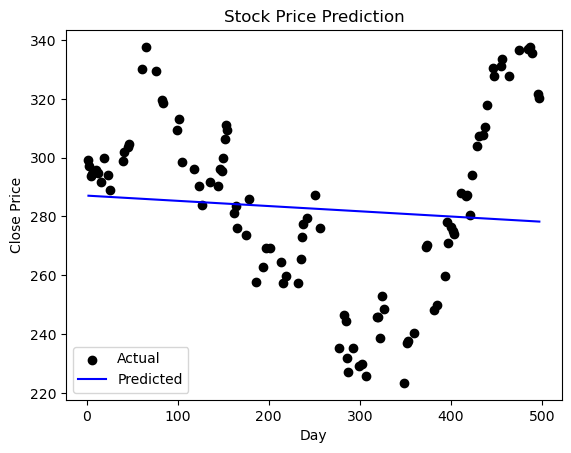

In [19]:
y_pred = model.predict(X_test)

# Define a function we can reuse to plot the model predictions
def plotModelPrediction(X, y, y_pred):
    # Create a DataFrame so that we can sort the values together by day and accurately compare the results in a plot
    comparison_data = pandas.DataFrame({
        'Actual_Close': y,
        'Predicted_Close': y_pred,
        'Day': X['Day']
    })
    # Setting the index to the day
    comparison_data.index = comparison_data['Day']
    # Sorting the DataFrame by day
    comparison_data.sort_index(inplace=True)
    # see the errors
    print('Mean Squared Error:', mean_squared_error(y, y_pred))
    # plot the predicted values against the actual values
    plot.scatter(comparison_data['Day'], comparison_data['Actual_Close'], color='black', label='Actual')
    plot.plot(comparison_data['Day'], comparison_data['Predicted_Close'], color='blue', label='Predicted')
    plot.xlabel('Day')
    plot.ylabel('Close Price')
    plot.title('Stock Price Prediction')
    plot.legend()
    plot.show()

plotModelPrediction(X_test, y_test, y_pred)

We then improved the model using polynomial regression. This time let's take a look at other techniques that can help us improve this model.

### 2.2 Feature Engineering

As you may have guessed, the stock market is very complex and is affected by many factors. We could consider adding more of these factors into our model if we want to build a more accurate stock price prediction application. Feature engineering is just that, it is the process of selecting and transforming the variables in your data to improve the model's performance. By considering additional features or transforming existing ones, we can potentially capture more complex relationships in the data.

#### 2.2.1 Creating New Features

If not enough features or the right features were present in our data, we could create some new features that capture some relationship in our data. For example, the price change could be added as a new feature by calculating the difference between consecutive closing prices. Let's take a look at how this new feature can be created and added to our model.

In [20]:
# Calculate the price change from the previous day
msft_data_copy = msft_data.copy()
msft_data_copy['Price Change'] = msft_data_copy['Close'].diff()

# Drop the first row since it doesn't have a previous day's price
msft_data_copy.dropna(inplace=True)

In the code above, we created a copy of the microsoft stock price data so that we can safely manipulate it and remove entries withouth worrying it will affect any code later on. We also created a new feature called 'Price Change', and with that, we're ready to train our model.

In [21]:
# Update the features X to include the new 'Price Change' feature
X = msft_data_copy[['Day', 'Price Change']]
# Also update the target variable y to match the new size
y = msft_data_copy['Close']
# Split the data and train the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

With our new model trained, it's now time to make some predictions and compare how well our model is now performing

Mean Squared Error: 1230.4799306072018


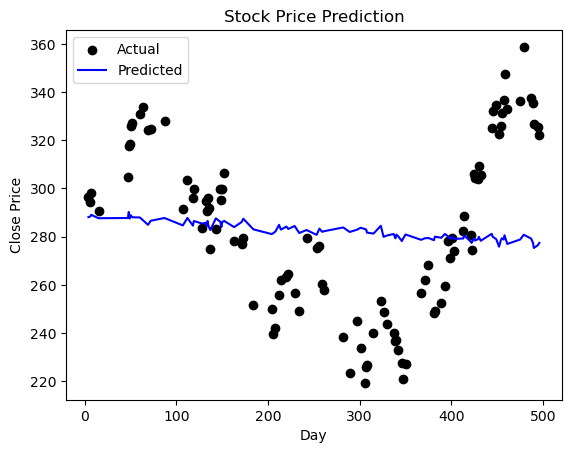

In [22]:
y_pred = model.predict(X_test)
plotModelPrediction(X_test, y_test, y_pred)

In this case, our new feature 'Price Change' didn't perform much better than our initial linear regression model. Not every feature will be useful, it is very important to select the right features for your model.  Let's now try to more carefully select features from our existing data to see how choosing the right features affects the model.

#### 2.2.2 Feature Selection

Let's first take a look at the data we have available and see what additional features we may want to include in our model

In [23]:
print(msft_price_data)

                                 Open        High         Low       Close  \
Date                                                                        
2021-08-19 00:00:00-04:00  283.552928  292.176692  283.503830  291.489136   
2021-08-20 00:00:00-04:00  294.386703  300.397798  292.756238  298.944122   
2021-08-23 00:00:00-04:00  297.853861  299.965597  296.478779  299.228943   
2021-08-24 00:00:00-04:00  299.592365  300.211159  296.626114  297.235077   
2021-08-25 00:00:00-04:00  298.885185  299.170033  295.074252  296.635956   
...                               ...         ...         ...         ...   
2023-08-14 00:00:00-04:00  320.711012  323.375354  319.403752  323.355408   
2023-08-15 00:00:00-04:00  322.317568  324.403149  320.221999  321.179962   
2023-08-16 00:00:00-04:00  320.799988  324.420013  319.799988  320.399994   
2023-08-17 00:00:00-04:00  320.540009  321.869995  316.209991  316.880005   
2023-08-18 00:00:00-04:00  314.489990  318.380005  311.549988  316.480011   

From the output above, we see that we have 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', and 'Stock Splits'. Selecting the right features can make a huge difference in our model's performance. Let's include the features that we think will have a large impact on the closing stock price, which is what we're trying to predict. The opening price of the stock 'Open', the highest it got in a day 'High' and the lowest the price got in the day 'Low' are all viable options, let's add them to our features and see how well our model performs.

In [24]:
msft_data['Open'] = msft_price_data['Open']
msft_data['High'] = msft_price_data['High']
msft_data['Low'] = msft_price_data['Low']

y = msft_data['Close']
X = msft_data[['Day', 'Open', 'High', 'Low']]

Now that we have our new set of features, let's get the new training and testing data and retrain our model

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

With our new model trained, it's now time to make some predictions and compare how well our model is now performing

Mean Squared Error: 2.728327452878783


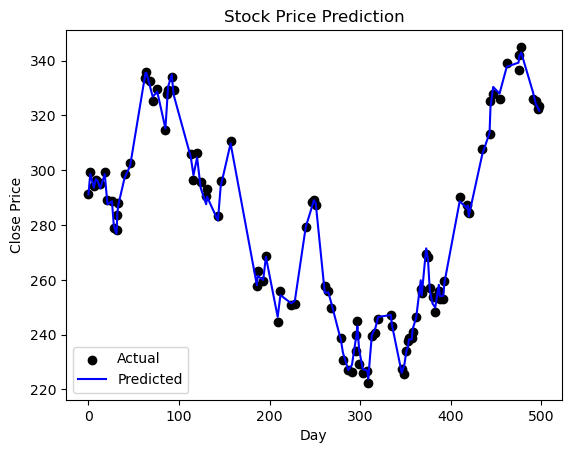

In [26]:
y_pred = model.predict(X_test)
plotModelPrediction(X_test, y_test, y_pred)

As we can see, from the Mean Squared Error (MSE) and from the plot itself, our model has significantly improved. This illustrates the impact that proper feature selection can have on your model's performance. It should be noted that feature selection is often an iterative and experimental process and domain knowledge can significantly influence the choice of features.

Now, it may seem like our model is performing really well, maybe too well. Having a model that performs exceptionally on training and test data might not be a good indicator. It could be a case of overfitting, where the model performs very well on data it's already seen but very poorly on new data, so special attention must be paid to these cases to ensure we have a truly performant model.

### 2.3 Underfitting
Imagine you're learning to play a new musical instrument, but you only practice playing simple scales without exploring any songs or techniques. You may master those scales, but when faced with a complex piece of music, you'll find yourself unprepared. This is akin to underfitting in machine learning. An underfit model is too simplistic; it fails to capture the underlying trend of the data, leading to poor performance on both the training data and unseen data. It often suffers from high bias, meaning it consistently misses the mark.

An example of underfitting is our first linear regression model, where our predictions consistently failed to predict the actual values.

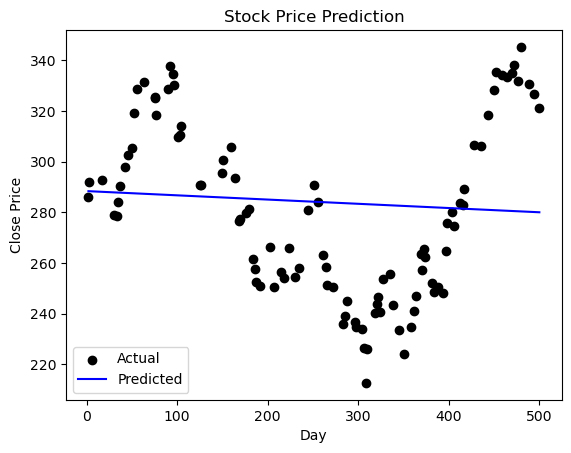

### 2.4 Overfitting
Now, imagine you're learning to play that same instrument, but you only focus on mastering one specific song. You become excellent at performing that song, but when faced with a different piece of music, you struggle. This may be an example of overfitting in machine learning, where a model performs exceptionally well on the training data but poorly on unseen data. An overfit model is highly specialized in the data it has seen and has failed to generalize the underlying pattern, leading to low performance on new data.

It isn't certain yet, but our last model could be an example of overfitting. The model fits the data too well, we'll see later how to detect and fix these issues.

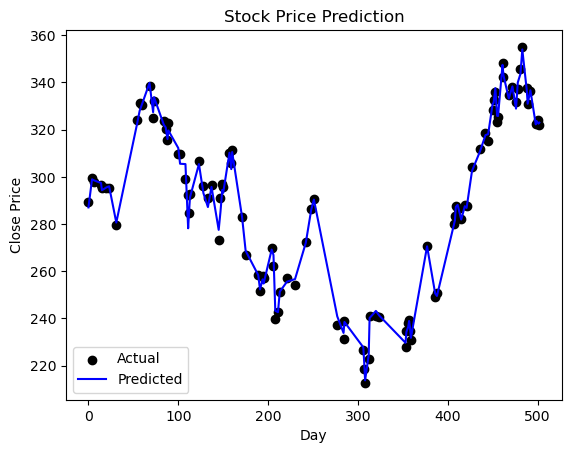

### 2.5 Variance and Bias

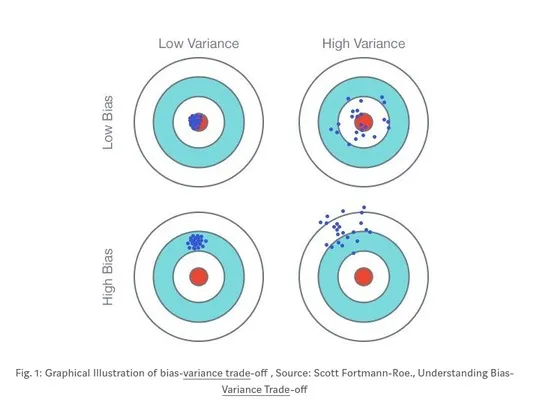

Think of bias and variance in terms of target practice with a bow and arrow.

- **Bias**: Bias is how far off you are from the target, on average. It reflects the model's accuracy. Imagine an archer consistently hitting the left of the target. The archer's aim is off, analogous to a model with high bias (underfitting). The model is too simple, missing the complexity (high bias), so it consistently makes the same error, reflecting a lack of accuracy.

- **Variance**: Variance is the spread of your shots. It reflects the model's flexibility. If an archer's arrows are scattered all around the target, it represents high variance (overfitting). In machine learning, a model with high variance is highly sensitive to the specific data it was trained on, fitting even the random noise. The model captures the training data well, including noise (high variance), showing high flexibility but too specialized, failing on new data

Here's a way to relate these concepts:

- **Underfitting**: High Bias, Low Variance
  - Like an archer consistently missing to the left (high bias) but with closely grouped arrows (low variance).
  - The model is too simple, missing the complexity (high bias), but not overly sensitive to the training data (low variance).

- **Overfitting**: Low Bias, High Variance
  - Like an archer hitting close to the bull's eye on average (low bias) but with arrows scattered all around (high variance).
  - The model captures the training data well, including noise (high variance), but is too specialized and fails on new data (low bias).

Bias is about the model's overall accuracy, and variance is about the model's flexibility. Balancing these two is key to creating a model that is just right – not too simple, not too complex, but capable of generalizing well from the training data to unseen data.

### 2.6 Detecting and Fixing Overfitting and Underfitting
Detecting and fixing overfitting and underfitting is crucial to building an effective model. There are various methods like cross-validation, learning curves, and regularization techniques that can help you identify whether your model is overfitting or underfitting

#### 2.6.1 Cross-Validation
Cross-validation is a resampling procedure used to check how well a model will perform on new, unseen data. It does this by dividing the data into parts and using different parts for training and testing the model. There are various methods of cross-validation depending on the needs and the nature of the dataset. Here's an overview of some popular methods:

**K-Fold Cross-Validation**:

K-Fold divides the data into "K" equal parts, known as "folds," and each fold is used once as a validation set. A common choice is 5 or 10 folds.

**Stratified K-Fold Cross-Validation**:

Stratified K-Fold follows the same procedure as K-Fold, but ensures that each fold has the same proportion of samples from each class. Useful with imbalanced datasets.

**Leave-One-Out Cross-Validation (LOOCV)**:

Leave-One-Out Cross-Validation (LOOCV) is a specialized cross-validation technique where each iteration takes a single data point, also known as a "row," "observation," or "sample," for testing, while the remaining data is used for training. This cycle is repeated for every data point in the dataset, so that each is tested exactly once. Although it gives a detailed evaluation, LOOCV can be computationally demanding and is often ideal for smaller datasets. It provides a balanced insight into how the model might perform on new, unseen data.

**Leave-P-Out Cross-Validation (LPOCV)**:

LPOCV generalizes LOOCV by leaving out "P" observations for validation. If P = 1, LPOCV is equivalent to LOOCV.

**Time Series Cross-Validation**:

For time-dependent data, Time Series Cross-Validation maintains the order of observations to respect temporal dependencies within the data.

By using these various cross-validation techniques, you can:
- **Estimate the Performance**: Use different parts of the data for training and testing to get a more accurate and robust estimation of the model's performance on unseen data.
- **Tune Hyperparameters**: Find the best hyperparameters for polynomial regression, regularization terms, etc., by trying different values and comparing the cross-validation scores.
- **Avoid Overfitting**: Reduce the risk of overfitting by validating the model on different subsets of the data.

To understand cross-validation further, we'll walk through an example of **K-fold cross-validation** and then apply it to our model in code:

**Step 1: Divide the Data**

In K-fold cross-validation, the data is divided into a number of equal parts, known as "folds." A common choice is 5 or 10 folds. Dividing the data into folds ensures that every data point is used for validation exactly once, providing a comprehensive evaluation.

For example, let's assume we have this dataset:

| X (Feature) | y (Target) |
|-------------|------------|
| 1           | 2          |
| 2           | 4          |
| 3           | 6          |
| 4           | 8          |
| 5           | 10         |
| 6           | 12         |

If we choose 3 folds, the data will get divided into 3 equal parts, each fold consisting of 2 samples (feature X, target y) pairs:

- Fold 1: Contains the first and second samples (1,2) and (2,4)
  - Features: 1 and 2 
  - Targets: 2 and 4
- Fold 2: Contains the third and fourth samples (3,6) and (4,8)
  - Features: 3 and 4
  - Targets: 6 and 8
- Fold 3: Contains the third and fourth samples (5,10) and (6,12)
  - Features: 5 and 6
  - Targets: 10 and 12

**Step 2: Train and Test the Model Using Folds**

In this step, the model is trained using all the folds except for one. If you're using 5-fold cross-validation, the model will be trained on 4 out of 5 folds. Afterwards the fold that was left out during training is used to test the model. The model's predictions on this fold are compared to the actual values to evaluate performance. This entire process is repeated equal to the number of folds specified, if 5 folds were specified, the training and testing steps are repeated 5 times. Each time the process is repeated, a different fold is left out for testing. This way, each fold is used as a test fold exactly once.

Continuing with our example, since we chose 3 folds, we will iterate through the training and testing steps 3 times, each time using a different fold for the validation step:

- **Iteration 1**: use Fold 1 as the testing fold (validation)
  - Training Data: 
    - Folds 2 and 3 are used to train the model. Which means the model is trained on the dataset: $\{(3,6), (4,8), (5,10), (6,12)\}$
  - Validation Data: 
    - Fold 1 is used to test the model. This means the model is tested using the dataset: $\{(1,2), (2,4)\}$
  - Result: let's assume the result is: `Error = 1`
- **Iteration 2**: use Fold 2 as the testing fold (validation)
  - Training Data: 
    - Folds 1 and 3 are used to train the model. Which means the model is trained on the dataset: $\{(1,2), (2,4), (5,10), (6,12)\}$ 
  - Validation Data: Fold 2
    - Fold 2 is used to test the model. This means the model is tested using the dataset: $\{(3,6), (4,8)\}$
  - Result: let's assume the result is: `Error = 1.5`
- **Iteration 3**: use Fold 3 as the testing fold (validation)
  - Training Data:
    - Folds 1 and 2 are used to train the model. Which means the model is trained on the dataset: $\{(1,2), (2,4), (3,6), (4,8)\}$ 
  - Validation Data: Fold 3
    - Fold 3 is used to test the model. This means the model is tested using the dataset: $\{(5,10), (6,12)\}$ 
  - Result: let's assume the result is: `Error = 0.5`

**Step 3: Analyzing the Results**

After we've performed cross-validation, the results of each test in each of the folds are collected. So if 5 folds were specified, we'll have 5 test results. Getting the average of all the results, the mean, we can gain an overall idea of how well the model is performing. Getting the variance of the results would give us an indication of the consistency of the model's performance. The variance is a measure of how much the results differ from the mean. If the variance is high, it means that the results across the folds are spread out and differ significantly from the mean. High variance might indicate that the model performs well on some folds but poorly on others. If the variance is low, the results are closer to the mean. Low variacne suggests that the model's performance is relatively consistent across the folds.

Continuing our example, from each iteration we obtained the following results:
- Iteration 1: `Error = 1`
- Iteration 2: `Error = 1.5`
- Iteration 3: `Error = 0.5`

The mean of these results is:
$\frac{(1 + 1.5 + 0.5)}{3} = 1$

For the variance, we calculate the average of the squared differences between each error and the mean error. The formula for variance is:

$$
\text{{Variance}} = \frac{{(E_1 - \mu)^2 + (E_2 - \mu)^2 + (E_3 - \mu)^2}}{n}
$$

where $ E_i $ is the error from each fold, $ \mu $ is the mean error, and $ n $ is the number of folds.

Assuming the errors from our manual example were $ 1, 1.5, $ and $ 0.5 $, and the mean error was $1$ as calculated above:

$$
\begin{align*}
\text{{Variance}} & = \frac{{(1 - 1)^2 + (1.5 - 1)^2 + (0.5 - 1)^2}}{3} \\
& = \frac{{0 + 0.25 + 0.25}}{3} \\
& \approx 0.167
\end{align*}
$$

Now let's use cross validation on our actual model so we can analyze this model's performance:

In [27]:
from sklearn.model_selection import cross_val_score

# Step 1: The 'cv=5' parameter divides the data into 5 folds
# Step 2: The 'cross_val_score' function automatically trains and tests the model on each fold
cross_val_results = cross_val_score(model, X, y, cv=5)

# Step 3: Print the results to analyze the model's performance
print("Cross-validation scores:", cross_val_results)
print("Mean cross-validation score:", cross_val_results.mean())
print("Variance of cross-validation score:", cross_val_results.var())

Cross-validation scores: [0.99203124 0.97281259 0.99035335 0.98692901 0.99430161]
Mean cross-validation score: 0.9872855620567563
Variance of cross-validation score: 5.8150340421730265e-05


From these results we see we have a variance that is very close to 0, meaning the results are consistent across the different folds. The mean of the cross validation scores were all close to 1. This won't mean much unless we know what error metric was used. By default, the `cross_val_score` uses the default scorer, error metric, specified by our model. For linear regression, [the default error metric used by sklearn is $R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score), or the coefficient of determination, which tells us how well our predictions follow the trends in the actual data. a value close to 1 means that the model has, on average, predicted the target variable quite accurately.

Based on these results, it is safe to say we have a good robust model that does not suffer from overfitting.

#### 2.6.2 Learning Curves

Learning curves are plots that show how the performance of a machine learning model improves as the amount of training data increases. They help diagnose bias and variance in a model, providing insights into how well the model is learning from the data.

The plots showing the learning curves typically include two lines:

- **Training Error**: This line shows how the model's error changes on the training data as the size of the training set increases.
- **Validation Error**: This line shows how the model's error changes on a validation set as the size of the training set increases.

Learning curves are plotted for different training sizes. You start by training the model on a very small subset of the training data and then gradually increase the size of the training data, measuring the model's performance each time it gets re-trained.  For each training set size, cross validation gets performed. Just as discussed previously, this means the each training data gets split into folds, where most of the folds get used to train the data and the remaining one gets used to validate it. In this way, for each training size, you get an error metric and a cross validation error, which get plotted as the training error and validation error.

Let's now take a look at what the learning curves look like for our model:


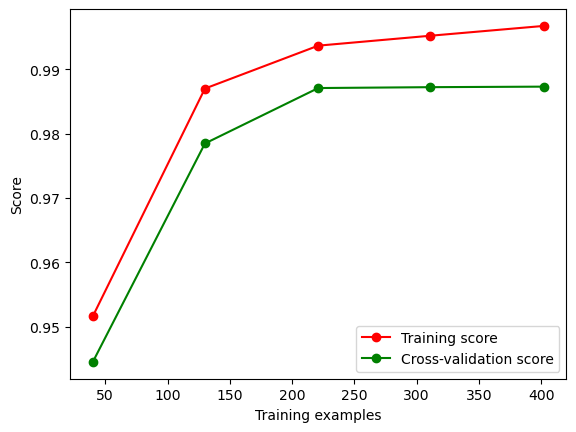

In [28]:
# This function will plot the training and validation errors against the training set size.
def plot_learning_curve(estimator, X, y):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=5)
    train_scores_mean = numpy.mean(train_scores, axis=1)
    test_scores_mean = numpy.mean(test_scores, axis=1)
    
    plot.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plot.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plot.xlabel("Training examples")
    plot.ylabel("Score")
    plot.legend(loc="best")
    plot.show()

plot_learning_curve(model, X, y)

As we can see, both the training score and the cross validation score follow a similar trend and are close to one another, which means we have a good fit model without underfitting or overfitting issues. Since these errors represent $R^2$ errors, if the training error and cross-validation score were both to start low and stay low, we would have a high bias, meaning the model would be too simple and underfit our data. Likewise, if the training score was very high but the cross-validation score was much lower, it would mean the model is overfitting, doing very well on training data but not on unseen data.

In linear regression, learning curves are not as frequently used as in more complex models, but they can still provide valuable insights, especially when you're working with polynomial features or other transformations.

#### 2.6.3 Regularization Techniques

Regularization techniques are another way to prevent overfitting in machine learning models. They essentially modify the original cost function in linear regression by adding a penalty term. This penalty term limist the size of the model's coefficients, which discourages the model from relying too heavily on a single feature and prevents it from fitting the noise in the training data that leads to overfitting. 

There are two main types of regularization techniques that are commonly used with linear regression: L1 regularization (Lasso) and L2 regularization (Ridge).

#### 2.6.3.1 Ridge Regularization (L2 Regularization)

Ridge regularization introduces a slight adjustment to the cost function that we learned [in the introduction to linear regression (section 3.4 Cost Function)](./Linear%20Regression.ipynb). It adds a penalty to the original Mean Squared Error (MSE) based on the size of the coefficients $ m $:

$$
J(m,b) = \frac{1}{n} \sum_{i=1}^{n} (y_i - (mx_i + b))^2 + \alpha \sum_{j=1}^{p} m_j^2
$$

Here's how to understand each part:
- The first part is the same as the original MSE, which measures how well the line fits the data.
- The second part $\alpha \sum_{j=1}^{p} m_j^2$ adds a penalty based on the size of the coefficients. This part works like a constraint, discouraging large values for the coefficients.
  - In this equation, $p$ represents the number of features
- $\alpha$ is a hyperparameter that controls the strength of the penalty. Larger $\alpha$ means a stronger constraint, making the coefficients closer to zero.

The Ridge technique keeps the coefficients small but does not eliminate them. It helps the model balance fitting the data and avoiding too much complexity, reducing the risk of overfitting.

To apply Ridge regulariztion to our model, we need to use the `Ridge` class from sklearn instead of simply using the `Linear Regression` class as we've been doing so far:

Mean Squared Error: 2.7283760152412113


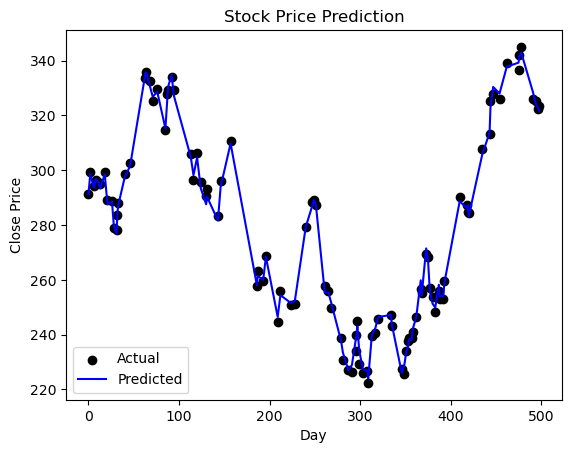

In [29]:
from sklearn.linear_model import Ridge
# Instead of LinearRegression() we use Ridge() with a specified alpha
ridge_model = Ridge(alpha=1.0)
# Fit the model using the training data
ridge_model.fit(X_train, y_train)
# Make predictions
y_pred = ridge_model.predict(X_test)
plotModelPrediction(X_test, y_test, y_pred)

The `alpha` parameter controls the strength of the regularization. You can adjust this value to find the optimal trade-off between fitting the data and avoiding overfitting.  Since we've already shown that our model doesn't suffer from overfitting, there haven't been much improvements this time around from using Ridge regularization.

#### 2.6.3.2 Lasso Regularization (L1 Regularization)

Lasso regularization makes a similar adjustment but uses a different penalty term:

$$
J(m,b) = \frac{1}{n} \sum_{i=1}^{n} (y_i - (mx_i + b))^2 + \alpha \sum_{j=1}^{p} | m_j |
$$

Here's what's different:
- Instead of squaring the coefficients, Lasso uses the absolute value of the coefficients: $\alpha \sum_{j=1}^{p} | m_j |$.
  - In this equation, $p$ represents the number of features
- This approach encourages some coefficients to be exactly zero, leading to sparsity. In other words, Lasso can remove unnecessary features by setting their coefficients to zero.

Like Ridge, Lasso also aims to create a balance, but with an added emphasis on feature selection. The choice between Ridge and Lasso would depend on the specific problem and the importance of identifying irrelevant features.

We can apply Lasso regularization to our model using the Lasso class from scikit-learn:

Mean Squared Error: 4.783234803362597


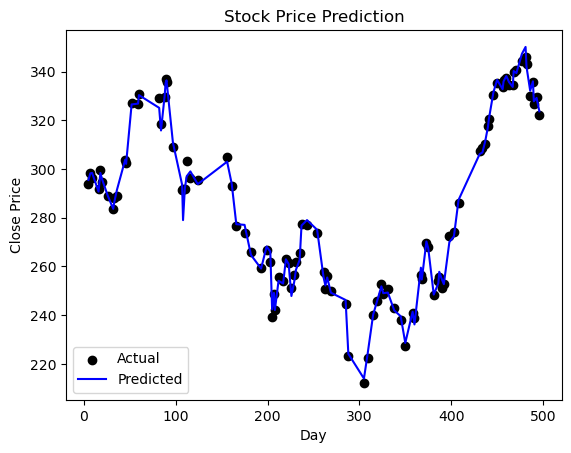

In [30]:
from sklearn.linear_model import Lasso
# add more features so we can use Lasso for feature selection
msft_data['Open'] = msft_price_data['Open']
msft_data['High'] = msft_price_data['High']
msft_data['Low'] = msft_price_data['Low']
msft_data['Dividends'] = msft_price_data['Dividends']
msft_data['Stock Splits'] = msft_price_data['Stock Splits']
msft_data['Volume'] = msft_price_data['Volume']

y = msft_data['Close']
X = msft_data[['Day', 'Open', 'High', 'Low', 'Dividends', 'Stock Splits', 'Volume']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Instead of LinearRegression() we use Lasso() with a specified alpha as our model
lasso_model = Lasso(alpha=1.0)

lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
plotModelPrediction(X_test, y_test, y_pred)


As mentioned previously, Lasso eliminates features that do not contribute to the model by shrinking them to exactly zero.  We can obtain the coefficients of these features, then ignore any feature with coefficient set to zero. In this way we'll be using Lasso for feature selection so we can focus only on the features that do matter to the predictive power of the model.

In [31]:
# Get the coefficients
coefficients = lasso_model.coef_
for feature, coef in zip(X.columns, coefficients):
    print(f"{feature}: {coef}")

Day: -0.00014758697496968507
Open: -0.4225075490043881
High: 0.7242131007043249
Low: 0.6966096084399181
Dividends: -0.0
Stock Splits: 0.0
Volume: -1.717147896953451e-08


With the specific choice we made for $\alpha$ (`alpha=1`), it seems like Dividends, Stock Splits don't contribute to our model. Volume seems to be very close to zero also suggesting it has very little influence in our model.  However, Lasso is very sensitive to the hyperparameter $\alpha$, so changing it to a different value could lead to very different results. Recall that $\alpha$ controls the amount of regularization that is applied, a higher value means more features will have zero coefficients.

In [32]:
lasso_model = Lasso(alpha=10.0)
lasso_model.fit(X_train, y_train)
y_pred = lasso_model.predict(X_test)
for feature, coef in zip(X.columns, lasso_model.coef_):
    print(f"{feature}: {coef}")

Day: 0.0
Open: 0.0
High: 0.5170380244625491
Low: 0.4731443185115338
Dividends: -0.0
Stock Splits: 0.0
Volume: -1.606070620159529e-08


In summary, both Ridge and Lasso augment the original cost function with penalties that guide the learning process towards simpler, more generalizable models. By using them, we are guiding our model not just to fit the data but to do so in a way that avoids overfitting and, in the case of Lasso, focuses on the most relevant features.

## 3 Conclusion

As we've seen, choosing the right set of features can have a significant impact on our model's performance. We utilize various techniques to detect and correct any issues of overfitting and underfitting to further enhance our model. We've shown that the features we've selected did indeed lead to a very performant model capable of predicting Closing stock prices quite accurately given a Day, Open, High, and Low features. However, as you might have guessed, these may not be the best features to choose if our goals are to make a stock price predicting model. It relies on features such as High and Low which aren't typically known until the end of the trading day. Similarly, specifying Open means this would only be a good model to predict the closing price during the same day, which may not be too helpful if you want to predict a stock price at some point in the future, say two weeks into the future.

Even though we've obtained a good model at this point, there are still many more ways in which it could be improved, and more appropriate features can be selected based on the use case.


### 3.1 Next Steps

We've worked a lot on linear regression, which is a great model when working with numeric quantities. However, what if we want a model that can answer questions like yes or no? What if we want to know whether an email is spam or not spam or whether a review about a movie exhibits positive or negative sentiment? Linear regression isn't suited for these kinds of problems, so in the next section let's learn about [Logistic Regression](../logistic-regression/Logistic%20Regression.ipynb) which can better help us with this.
